# lambda cdm

(-100.0, 100.0)

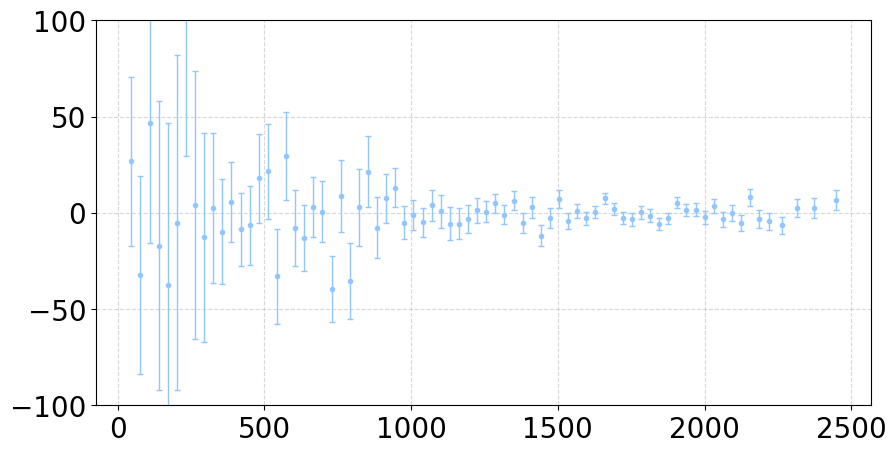

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# load the data
filename = "/Users/bellamarco01/uni/1_master_thesis/error_Planck_2020/TT_residuals.dat"
data = np.loadtxt(filename, usecols=[1,2,3,4,5],skiprows=1)

# print(data)
# columns
lmean  = data[:,0]
lmin   = data[:,1]
lmax   = data[:,2]
NPIPE_res = data[:,3]
Dl_err = data[:,4]
# Plik_res  = data[:,5]
# Plik_err  = data[:,6]

import plotting.plotting as pl

fig,axs = pl.new_fig(figsize=[10,5],nrows=1,ncols=1)

plt.errorbar(lmean,NPIPE_res, yerr=Dl_err,
        fmt='o',
        markersize=3,
        elinewidth=1,
        capsize=2,
        label='Planck 2018 TT')
plt.ylim([-100,100])
# print(NPIPE_res)

In [25]:
from classy import Class
import numpy as np
LambdaCDM = Class()
# 1807.06209 table 2, TT,TE,EE+lowE+lensing 
# LambdaCDM.set({'omega_b':0.02237,
#                'omega_cdm':0.1200,
#             #    '100theta_s':1.04110,
#                'H0':67.36,
#                'ln10^{10}A_s':3.044,
#                'n_s':0.9649,
#                'tau_reio':0.0544,
#                'N_mscf':0,
#                "do_shooting": "no",
#                }
            #    )

# https://hal.science/hal-04231374/file/aa48015-23.pdf
LambdaCDM.set({'omega_b':0.02218,
               'omega_cdm':0.1197,
            #    '100theta_s':1.04110,
               'H0':67.26,
               'ln10^{10}A_s':3.035,
               'n_s':0.9635,
               'tau_reio':0.0517,
               'N_mscf':0,
               "do_shooting": "no",
               }
               )



LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes'})

LambdaCDM.compute()
bg = LambdaCDM.get_background()


cl_tot_0 = LambdaCDM.lensed_cl(2500)

ell = cl_tot_0['ell']
cl_tt_0 = cl_tot_0['tt']
T_cmb = 2.725
T_uK = T_cmb*1e6
D_ell_0 = ell*(ell+1)/(2*np.pi) * cl_tt_0 * T_uK**2

NPTS = 500  # choose 100, 200, 300… depending on how small you want the file

D_tt_0_interp = interp1d(
   ell,
   D_ell_0,
   kind='linear',
   bounds_error=False,
   fill_value='extrapolate'
)

# Dl_binned = np.array([
#     bin_integrated(D_tt_interp, edges[i], edges[i+1])
#     for i in range(len(ell_c))
# ])
# residuals = (Dl_binned - Dl )/ Dl_binned_0

# evaluate at Planck ell's
Dl_0_small = D_tt_0_interp(lmean)

ell_data = lmean
ell_c = lmean
Dl = (Dl_0_small + NPIPE_res)

bg = LambdaCDM.get_background()

z_lcdm = bg['z'] #redshift
H_lcdm = bg['H [1/Mpc]'] #hubble rate

NPTS = 500  # choose 100, 200, 300… depending on how small you want the file

idx = np.round(np.linspace(0, len(z_lcdm) - 1, NPTS)).astype(int)

z_small_lcdm       = z_lcdm[idx]
H_small_lcdm  = H_lcdm[idx]

residuals = (Dl_0_small - Dl )/ Dl_0_small

# multi-axion

In [26]:
# call this from terminal to sync
# rsync -avz --progress bella@lupm-slurm.lupm.in2p3.fr:/home/bella/mini_reconstruction_tool ~/uni/1_master_thesis/tools/output_remote


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def extract_residuals(dir):
    # -----------------------------
    # ️ Loop over samples and collect data
    # -----------------------------
    npz_files = sorted(dir.glob("*_sample_*.npz"))
    all_z = []
    all_fEDE = []
    all_H =[]
    all_ell = []
    all_cl_tt = []
    weights = []

    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        all_H.append(data["H"])
        all_ell.append(data["ell"])
        all_cl_tt.append(data["cl_tt"])
        weights.append(data["weight"])

    weights=np.array(weights)

    # Convert lists to arrays
    ell = all_ell[0]  # assume same ell grid for all samples
    print(ell)

    # shape: (n_samples, n_ell)
    T_cmb = 2.725
    T_uK = T_cmb*1e6
    D_tt_all = np.array([
        ell*(ell+1)*cl/(2*np.pi)* T_uK**2 for cl in all_cl_tt
    ])

    residuals = (D_tt_all - D_ell_0 )/ D_ell_0

    n_samples, n_ell = residuals.shape
    # weights = np.ones(n_samples)   # or real MCMC weights

    # lower_68 = np.percentile(residuals, 16, axis=0)
    # upper_68 = np.percentile(residuals, 84, axis=0)
    # lower_95 = np.percentile(residuals, 2.5, axis=0) 
    # upper_95 = np.percentile(residuals, 97.5, axis=0)
    lower_68 = np.zeros(n_ell)
    upper_68 = np.zeros(n_ell)
    lower_95 = np.zeros(n_ell)
    upper_95 = np.zeros(n_ell)

    for j in range(n_ell):
        vals = residuals[:, j]

        lower_68[j], upper_68[j] = weighted_percentile(
            vals, weights, [16, 84]
        )
        lower_95[j], upper_95[j] = weighted_percentile(
            vals, weights, [2.5, 97.5]
        )
    return lower_95, lower_68, upper_68, upper_95

def weighted_percentile(values, weights, percentiles):
    """
    values: (N_samples,)
    weights: (N_samples,)
    percentiles: list or array in [0, 100]
    """
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]

    cdf = np.cumsum(weights)
    cdf /= cdf[-1]

    return np.interp(np.array(percentiles) / 100.0, cdf, values)


def extract_bf(bf_file):
    bf_z = []
    bf_fEDE = []
    bf_H =[]
    bf_ell = []
    bf_cl_tt = []

    data = np.load(str(bf_file))
    bf_z= (data["z"])
    bf_fEDE= (data["f_EDE"])
    bf_H= (data["H"])
    bf_ell= (data["ell"])
    bf_cl_tt= (data["cl_tt"])
    D_tt_bf = np.array(bf_ell*(bf_ell+1)*bf_cl_tt/(2*np.pi))
    residuals_bf = (bf_cl_tt - cl_tt_0 )/ cl_tt_0  # ΔD_ell = sample - LCDM
    residuals_bf_H = (bf_H - H_small_lcdm )/ H_small_lcdm  # ΔD_ell = sample - LCDM
    return residuals_bf, residuals_bf_H, bf_fEDE, bf_z

def extract_bg(dir):
    # -----------------------------
    # ️ Loop over samples and collect data
    # -----------------------------
    all_z = []
    all_fEDE = []
    all_H =[]
    all_ell = []
    all_cl_tt = []
    weights = []
    npz_files = sorted(dir.glob("*_sample_*.npz"))

    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        all_H.append(data["H"])
        all_ell.append(data["ell"])
        all_cl_tt.append(data["cl_tt"])
        weights.append(data["weight"])

    all_fEDE = np.array(all_fEDE)      # shape: (N_samples, N_z)
    all_H = np.array(all_H)      # shape: (N_samples, N_z)
    weights = np.array(weights)
    # weights = np.ones(n_samples)   # or real MCMC weights

    # lower_68 = np.percentile(residuals, 16, axis=0)
    # upper_68 = np.percentile(residuals, 84, axis=0)
    # lower_95 = np.percentile(residuals, 2.5, axis=0) 
    # upper_95 = np.percentile(residuals, 97.5, axis=0)
    lower_68 = np.zeros(all_fEDE.shape[1])
    upper_68 = np.zeros_like(lower_68)
    lower_95 = np.zeros_like(lower_68)
    upper_95 = np.zeros_like(lower_68)
    for j in range(all_fEDE.shape[1]):
        vals = all_fEDE[:, j]
        w = weights

        lower_68[j], upper_68[j] = weighted_percentile(vals, w, [16, 84])
        lower_95[j], upper_95[j] = weighted_percentile(vals, w, [2.5, 97.5])

    lower_68_H = np.zeros(all_H.shape[1])
    upper_68_H = np.zeros_like(lower_68)
    lower_95_H = np.zeros_like(lower_68)
    upper_95_H = np.zeros_like(lower_68)

    for j in range(all_H.shape[1]):  # loop over z
        vals = (all_H[:, j] - H_small_lcdm[j])/H_small_lcdm[j]
        w = weights

        lower_68_H[j], upper_68_H[j] = weighted_percentile(vals, w, [16, 84])
        lower_95_H[j], upper_95_H[j] = weighted_percentile(vals, w, [2.5, 97.5])
    return all_z, [lower_95, lower_68, upper_68, upper_95], [lower_95_H, lower_68_H, upper_68_H, upper_95_H]

def bf_vs_planck(bf_file):
    bf_z = []
    bf_fEDE = []
    bf_H =[]
    bf_ell = []
    bf_cl_tt = []

    data = np.load(str(bf_file))
    bf_ell= (data["ell"])
    bf_cl_tt= (data["cl_tt"])
    D_tt_bf = np.array(bf_ell*(bf_ell+1)*bf_cl_tt/(2*np.pi))*T_uK**2

    from scipy.interpolate import interp1d

    # build interpolator
    D_tt_interp = interp1d(
        ell,
        D_tt_bf,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )

    # Dl_binned = np.array([
    #     bin_integrated(D_tt_interp, edges[i], edges[i+1])
    #     for i in range(len(ell_c))
    # ])
    # residuals = (Dl_binned - Dl )/ Dl_binned_0

    # evaluate at Planck ell's
    Dl_small = D_tt_interp(ell_data)

    residuals = (Dl_small - Dl )


    # D_tt_small = D_tt_interp(ell_data)

    return residuals


In [27]:
# -----------------------------
#1pd
# -----------------------------
data_dirs = ["/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1pd/output_class/", 
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1psd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2pd/output_class/", 
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2psd/output_class/"]

residuals_bf_all = []
bf_vs_planck_all = []
lower_95_all = []
upper_95_all = []
lower_68_all = []
upper_68_all = []
for data_dir in data_dirs:
    dir = Path(data_dir)  # adjust path if needed
    bf_file = data_dir+ "bestfit.npz"
    lower_95, lower_68, upper_68, upper_95 = extract_residuals(dir)
    all_zd, ci_fede, ci_h = extract_bg(dir)
    residuals_bf, residuals_bf_H, f_ede, z_bf  = extract_bf(bf_file)
    res_vs_planck = bf_vs_planck(bf_file)
    residuals_bf_all.append(residuals_bf)
    bf_vs_planck_all.append(res_vs_planck)
    lower_95_all.append(lower_95)
    upper_95_all.append(upper_95)
    lower_68_all.append(lower_68)
    upper_68_all.append(upper_68)

[   0    1    2 ... 2498 2499 2500]


/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_23717/2352827757.py:44: RuntimeWarning: invalid value encountered in divide
  residuals = (D_tt_all - D_ell_0 )/ D_ell_0
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_23717/2352827757.py:99: RuntimeWarning: invalid value encountered in divide
  residuals_bf = (bf_cl_tt - cl_tt_0 )/ cl_tt_0  # ΔD_ell = sample - LCDM


[   0    1    2 ... 2498 2499 2500]
[   0    1    2 ... 2498 2499 2500]
[   0    1    2 ... 2498 2499 2500]


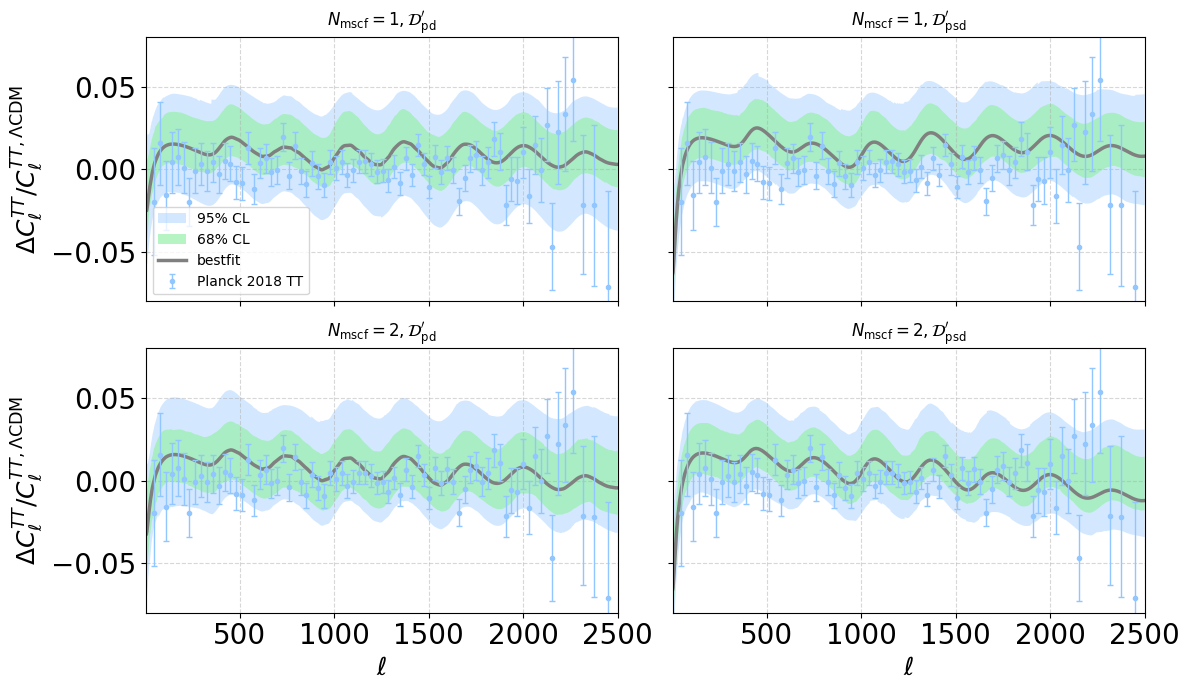

Saved residuals.pdf to /Users/bellamarco01/uni/1_master_thesis/thesis/plots


In [29]:
import plotting.plotting as pl

fig,axs = pl.new_fig(figsize=[12,7],nrows=2,ncols=2)

names = [r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{psd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{psd}$',]

for i in [0,1,2,3]:
    residuals_bf = residuals_bf_all[i]
    lower_95 = lower_95_all[i]
    upper_95 = upper_95_all[i]
    lower_68 = lower_68_all[i]
    upper_68 = upper_68_all[i]
    ax = axs[i]


    ax.fill_between(
    ell, lower_95, upper_95,
    alpha=0.4, label="95% CL"
    )

    ax.fill_between(
    ell, lower_68, upper_68,
    alpha=0.7, label="68% CL"
    )
    ax.plot(ell, residuals_bf, linewidth=2.5, label='bestfit',color='grey')

    # plt.xlabel(r"$\ell$")
    # plt.ylabel(r"$D_\ell^{TT}$ [$\mu K^2$]")
    ax.set_title(names[i])
    ax.set_xlim(2, 2500)
    # plt.ylim(0,0.1)
    ax.ticklabel_format(style='plain', axis='both')
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    # ax.set_ylim(-1.5,-.5)
    ax.errorbar(
        ell_data, residuals,
        yerr=Dl_err/Dl_0_small,
        fmt='o',
        markersize=3,
        elinewidth=1,
        capsize=2,
        label='Planck 2018 TT'
    )

axs[2].set_xlabel(r"$\ell$",fontsize=18)
axs[3].set_xlabel(r"$\ell$",fontsize=18)
axs[0].set_ylabel(r"$\Delta C_\ell^{TT} / C_\ell^{TT,\Lambda\text{CDM}}$",fontsize=18)
axs[2].set_ylabel(r"$\Delta C_\ell^{TT} / C_\ell^{TT,\Lambda\text{CDM}}$",fontsize=18)
# plt.title("2psd CMB TT Residuals")
plt.xlim(2, 2500)
plt.ylim(-.08,0.08)
axs[0].legend()
plt.tight_layout()

plt.show()
fig.save("residuals")

<>:30: SyntaxWarning: invalid escape sequence '\L'
<>:51: SyntaxWarning: invalid escape sequence '\L'
<>:30: SyntaxWarning: invalid escape sequence '\L'
<>:51: SyntaxWarning: invalid escape sequence '\L'
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_23717/2265504170.py:30: SyntaxWarning: invalid escape sequence '\L'
  axs[0].axhline(y=0, linewidth=2, label='$\Lambda$CDM', color='grey')
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_23717/2265504170.py:51: SyntaxWarning: invalid escape sequence '\L'
  label='$\Lambda$CDM', color='grey'
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_23717/2265504170.py:30: SyntaxWarning: invalid escape sequence '\L'
  axs[0].axhline(y=0, linewidth=2, label='$\Lambda$CDM', color='grey')
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_23717/2265504170.py:51: SyntaxWarning: invalid escape sequence '\L'
  label='$\Lambda$CDM', color='grey'


ValueError: 'topleft' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

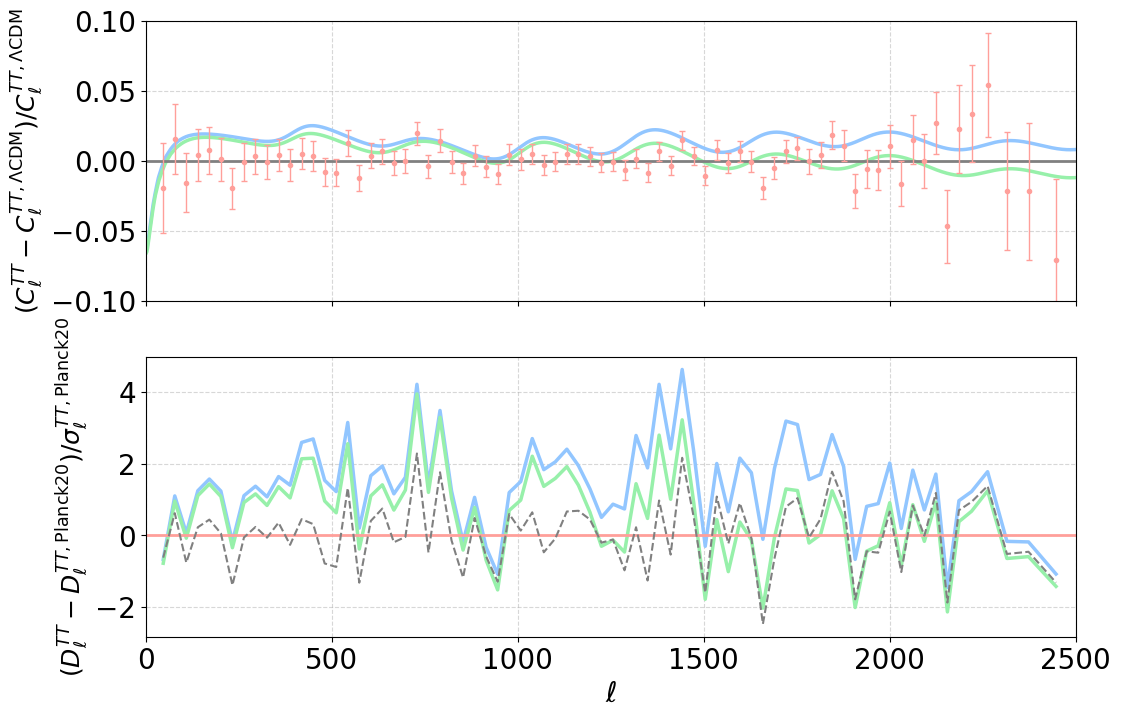

In [47]:
import plotting.plotting as pl

# fig,axs = pl.new_fig(figsize=[7,10],nrows=2,ncols=1)
fig, axs = pl.new_fig(nrows=2, ncols=1, figsize=(12,8), sharey=False)
names = [r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{psd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{psd}$',]


for i in [1,3]:
    residuals_bf = residuals_bf_all[i]
    # sigma = (upper_68_all[i] - lower_68_all[i] )/ 2
    # build interpolator
    # res_interp = interp1d(
    #     ell,
    #     residuals_bf,
    #     kind='linear',
    #     bounds_error=False,
    #     fill_value='extrapolate'
    # )

    delta = Dl_err
    # evaluate at Planck ell's
    residuals_bf_int = bf_vs_planck_all[i]

    # residuals = (Dl_0 - Dl )/ Dl_0


    axs[0].plot(ell, residuals_bf, linewidth=2.5, label='bestfit '+names[i])
    axs[1].plot(ell_data, residuals_bf_int/delta, linewidth=2.5, label='bestfit '+names[i])

axs[0].axhline(y=0, linewidth=2, label='$\Lambda$CDM', color='grey')
from plotting.plotting import COLORS
axs[1].axhline(y=0, linewidth=2, color=COLORS[2])
axs[0].errorbar(
    ell_data, residuals,
    yerr=Dl_err/Dl_0_small,
    fmt='o',
    markersize=3,
    elinewidth=1,
    capsize=2,
    label='Planck 2020 TT',
#     color = 'grey'
)
for ax in axs:
    # plt.xlabel(r"$\ell$")
    # plt.ylabel(r"$D_\ell^{TT}$ [$\mu K^2$]")
    ax.set_xlim(0, 2500)
    # ax.set_ylim(-0.05,0.05)

axs[1].plot(
    ell_data, residuals*Dl/Dl_err, linestyle='--',
    label='$\Lambda$CDM', color='grey'
)
# axs[0].set_ylim(-0.05,0.05)
# axs[1].set_ylim(-1,1)
axs[0].set_ylim(-0.1,0.1)
# axs[1].set_ylim(-3,7)

axs[1].set_xlabel(r"$\ell$",fontsize=20)
axs[1].set_ylabel(r"$(D_\ell^{TT} - D_\ell^{TT,\text{Planck20}}) / \sigma_\ell^{TT,\text{Planck20}}$",fontsize=18)
axs[0].set_ylabel(r"$(C_\ell^{TT} - C_\ell^{TT,\Lambda\text{CDM}})/ C_\ell^{TT,\Lambda\text{CDM}}$",fontsize=18)

# plt.title("2psd CMB TT Residuals")
# plt.ylim(0,0.1)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()
fig.save("bf_residuals_npipe")

NameError: name 'z_bf_1pd' is not defined

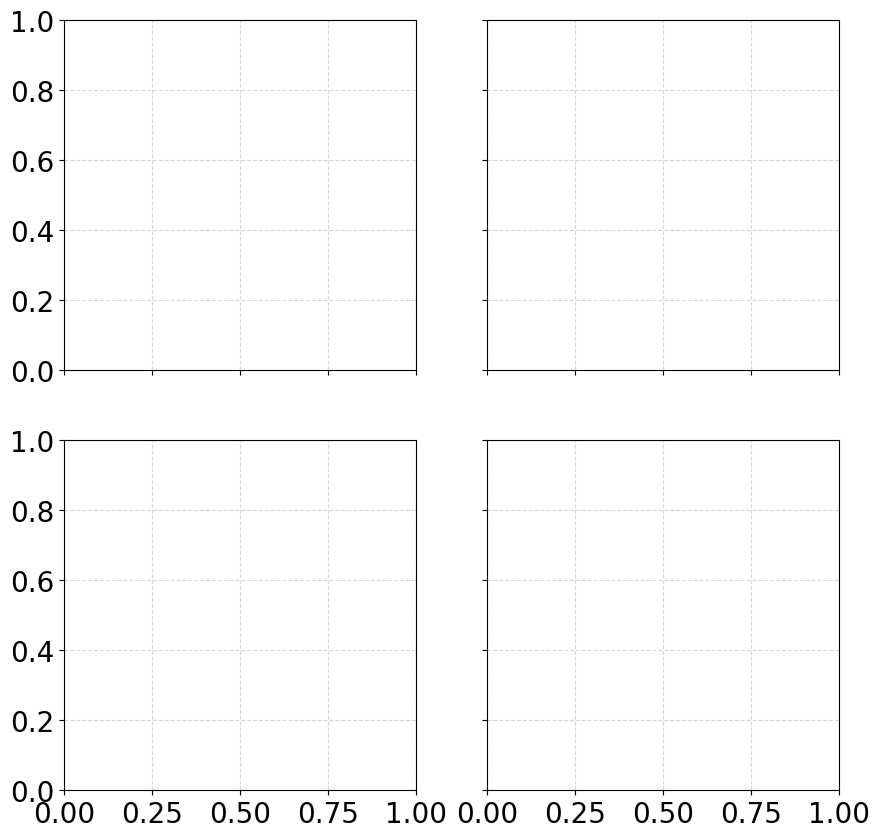

In [27]:
import plotting.plotting as pl

fig,axs = pl.new_fig(figsize=[10,10],nrows=2,ncols=2)
axs[0].plot(np.log10(1 + z_bf_1pd), residuals_bf_H_1pd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[0].fill_between(np.log10(1 + all_z_1pd[0]), ci_h_1pd[1], ci_h_1pd[2], alpha=0.7, label="68% CL")
axs[0].fill_between(np.log10(1 + all_z_1pd[0]), ci_h_1pd[0], ci_h_1pd[3], alpha=0.4,label="95% CL")

# axs[0].set_xlabel(r"$\log_{10}(1+z)$",fontsize=18)
#plt.yscale('log')
axs[0].set_ylabel(r"$[H(z)-H_{\Lambda CDM}(z)]/H_{\Lambda CDM}(z)$",fontsize=18)
axs[0].set_title(r'1 axion, $\mathcal{D}_\text{pd}^\prime$',fontsize=18)
axs[0].set_xlim(0,6)
# plt.title(r"2pd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)

axs[1].plot(np.log10(1 + z_bf_1psd), residuals_bf_H_1psd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[1].fill_between(np.log10(1 + all_z_1psd[0]), ci_h_1psd[1], ci_h_2psd[2], alpha=0.7, label="68% CL")
axs[1].fill_between(np.log10(1 + all_z_1psd[0]), ci_h_1psd[0], ci_h_2psd[3], alpha=0.4,label="95% CL")
axs[1].set_title(r'1 axion, $\mathcal{D}_\text{psd}^\prime$',fontsize=18)

axs[2].plot(np.log10(1 + z_bf_2pd), residuals_bf_H_2pd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[2].fill_between(np.log10(1 + all_z_2pd[0]), ci_h_2pd[1], ci_h_2pd[2], alpha=0.7, label="68% CL")
axs[2].fill_between(np.log10(1 + all_z_2pd[0]), ci_h_2pd[0], ci_h_2pd[3], alpha=0.4,label="95% CL")

axs[2].set_xlabel(r"$\log_{10}(1+z)$",fontsize=18)
#plt.yscale('log')
axs[2].set_ylabel(r"$[H(z)-H_{\Lambda CDM}(z)]/H_{\Lambda CDM}(z)$",fontsize=18)
axs[2].set_title(r'2 axions, $\mathcal{D}_\text{pd}^\prime$',fontsize=18)
axs[2].set_xlim(0,6)
# plt.title(r"2pd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)

axs[3].plot(np.log10(1 + z_bf_2psd),  residuals_bf_H_2psd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[3].fill_between(np.log10(1 + all_z_2psd[0]), ci_h_2psd[1], ci_h_2psd[2], alpha=0.7, label="68% CL")
axs[3].fill_between(np.log10(1 + all_z_2psd[0]), ci_h_2psd[0], ci_h_2psd[3], alpha=0.4,label="95% CL")
axs[3].set_title(r'2 axions, $\mathcal{D}_\text{psd}^\prime$',fontsize=18)



plt.xlabel(r"$\log_{10}(1+z)$",fontsize=18)
#plt.yscale('log')
# plt.ylabel(r"$[H(z)-H_{\Lambda CDM}(z)]/H_{\Lambda CDM}(z)$")
plt.xlim(0,5)
# plt.title(r"2psd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.save("12pdpsdh")

In [ ]:
import plotting.plotting as pl

fig,axs = pl.new_fig(figsize=[10,10],nrows=2,ncols=2)
axs[0].plot(np.log10(1 + z_bf_1pd), f_ede_1pd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[0].fill_between(np.log10(1 + all_z_1pd[0]), ci_fede_1pd[0], ci_fede_1pd[3], alpha=0.4,label="95% CL")
axs[0].fill_between(np.log10(1 + all_z_1pd[0]), ci_fede_1pd[1], ci_fede_1pd[2], alpha=0.7, label="68% CL")

# axs[0].set_xlabel(r"$\log_{10}(1+z)$",fontsize=18)
#plt.yscale('log')
axs[0].set_ylabel(r"$f_\text{ax}$",fontsize=18)
axs[0].set_title(r'1 axion, $\mathcal{D}_\text{pd}^\prime$',fontsize=18)
axs[0].set_xlim(0,6)
# plt.title(r"2pd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)

axs[1].plot(np.log10(1 + z_bf_1psd), f_ede_1psd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[1].fill_between(np.log10(1 + all_z_1psd[0]), ci_fede_1psd[0], ci_fede_2psd[3], alpha=0.4,label="95% CL")
axs[1].fill_between(np.log10(1 + all_z_1psd[0]), ci_fede_1psd[1], ci_fede_2psd[2], alpha=0.7, label="68% CL")
axs[1].set_title(r'1 axion, $\mathcal{D}_\text{psd}^\prime$',fontsize=18)

axs[2].plot(np.log10(1 + z_bf_2psd), f_ede_2pd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[2].fill_between(np.log10(1 + all_z_2pd[0]), ci_fede_2pd[0], ci_fede_2pd[3], alpha=0.4,label="95% CL")
axs[2].fill_between(np.log10(1 + all_z_2pd[0]), ci_fede_2pd[1], ci_fede_2pd[2], alpha=0.7, label="68% CL")

axs[2].set_xlabel(r"$\log_{10}(1+z)$",fontsize=18)
#plt.yscale('log')
axs[2].set_ylabel(r"$f_\text{ax}$",fontsize=18)
axs[2].set_title(r'2 axions, $\mathcal{D}_\text{pd}^\prime$',fontsize=18)
axs[2].set_xlim(0,6)
# plt.title(r"2pd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)

axs[3].plot(np.log10(1 + z_bf_2psd), f_ede_2psd, color='black',alpha=0.5, lw=2.5, label="bestfit")
# 95% confidence interval
# 68% confidence interval
# Median line
axs[3].fill_between(np.log10(1 + all_z_2psd[0]), ci_fede_2psd[0], ci_fede_2psd[3], alpha=0.4,label="95% CL")
axs[3].fill_between(np.log10(1 + all_z_2psd[0]), ci_fede_2psd[1], ci_fede_2psd[2], alpha=0.7, label="68% CL")
axs[3].set_title(r'2 axions, $\mathcal{D}_\text{psd}^\prime$',fontsize=18)



plt.xlabel(r"$\log_{10}(1+z)$",fontsize=18)
#plt.yscale('log')
plt.xlim(2.75,4.75)
# plt.title(r"2psd Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=25)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.save("12pdpsd_fede")

In [ ]:
bf_z = []
bf_fEDE = []
bf_H =[]
bf_ell = []
bf_cl_tt = []

data = np.load("/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1pd/output_class/bestfit.npz")
bf_z= (data["z"])
bf_fEDE= (data["f_EDE"])
bf_H= (data["H"])
bf_ell= (data["ell"])
bf_cl_tt= (data["cl_tt"])

plt.plot(bf_ell[500:], bf_cl_tt[500:], label='1 axion bestfilt Cl')
plt.plot(ell[500:], cl_tt_0[500:], label='lcdm bestfit cl')
plt.legend()
# plt.yscale('log')
